# Testing on grids

In [1]:
import os
from os import listdir
from os.path import isfile, join
import importlib
from IPython.display import clear_output
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy as sc
import pickle
import sys
depth = '../'
for i in range(7):
    sys.path.append(i*depth)
from MRF.Training_parameters import *
from MRF.BaseModel import *
from MRF.Projection import *
from MRF.models import *
import MRF
from MRF.Offline import Network, Data_class, Performances
import matplotlib.image as mpimg
clear_output()
import torch

plt.rcParams["axes.grid"] = False
root = 6*depth

## 1) Loading basis for projection and settings parameters

In [2]:
u=sc.io.loadmat(root+'paper_data/basis_for_compress.mat')['u']

grid = 64 
font = 10
font_large=12

R=13
noise_level=1/200
PD_mag = 100*noise_level 

## 2) Loading grids

In [3]:
#grid 64
root64 = '../test_grid64/'

#m0s T1
finger_name = 'fingerprints_m0sT1.mat'
crb_name = 'CRBs_m0sT1.mat'
param_name = 'params_m0sT1.mat'

fingerprints_ori64_m0sT1 = sc.io.loadmat(root64+finger_name)['fingerprints']
params64_m0sT1 = sc.io.loadmat(root64+param_name)['params']
CRBs_ori64_m0sT1 = sc.io.loadmat(root64+crb_name)['CRBs']

#T1 T2f
finger_name = 'fingerprints_T1T2f.mat'
crb_name = 'CRBs_T1T2f.mat'
param_name = 'params_T1T2f.mat'

fingerprints_ori64_T1T2f = sc.io.loadmat(root64+finger_name)['fingerprints']
params64_T1T2f = sc.io.loadmat(root64+param_name)['params']
CRBs_ori64_T1T2f = sc.io.loadmat(root64+crb_name)['CRBs']

## 3) Functions computing estimates on grids

In [11]:
########### all result analysis functions

#m0s T1 testgrid        
def m0s_T1_test_grid(fingerprints,params,CRBs_original,save_path,model_name,model,noise_level=0.01,epo='',PD_mag=0.5,grid=64):
    save_root= save_path+'/'+model_name
    if not os.path.exists(save_root):
            os.makedirs(save_root)
    parametersm0s = []
    parameterst1 = []
    parameterst2 = []

    with open(root+'settings_files_offline/settings_'+ model_name+'.pkl', 'rb') as f:
        settings = pickle.load(f)
        settings['namepca'] = root+'paper_data/basis_for_compress.mat'
        net = torch.load(join(root+'save_networks_offline','network_'+model_name+str(epo)),map_location='cpu')
        training_parameters = Training_parameters(settings['batch_size'], 1, settings['nb_epochs'], settings['params'], settings['normalization'], settings['complex'])
        projection = Projection(settings['start_by_projection'], settings['dimension_projection'], settings['initialization'], settings['normalization'], settings['namepca'], settings['complex'])
        data_class = Data_class(training_parameters, settings['noise_type'], settings['noise_level'], 
                                       settings['minPD'], settings['maxPD'], settings['nb_files'], settings['path_files'])
        validation_settings = {'validation': settings['validation'],'small_validation_size': settings['small_validation_size'], 'validation_size': settings['validation_size']}
        netw = model.model(projection=projection,nb_params=len(settings['params']))
        device = torch.device('cpu')
        netw.load_state_dict(net['NN'])
        netw.to(device)
        netw.eval()
        with torch.no_grad():
            for k in range(200):
                vec = fingerprints 

                # PD scale complex
                PD =  (PD_mag) * np.exp(1j * 2 * np.pi * np.random.uniform(0,1,fingerprints.shape[0]))
                PD_real = PD.real
                PD_imag = PD.imag

                PD = np.stack([PD_real,PD_imag],1)
                PD_real = np.tile(PD_real.reshape((-1, 1)), (1, vec.shape[1]))
                PD_imag = np.tile(PD_imag.reshape((-1, 1)), (1, vec.shape[1]))

                if len(vec.shape)==3:
                    vec_real = vec[:,:,0] * PD_real - vec[:,:,1]*PD_imag
                    vec_imag = vec[:, :, 1] * PD_real + vec[:, :, 0] * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                else:
                    vec_real = vec * PD_real
                    vec_imag = vec * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                fingers = vec

                PD = PD.reshape(-1, 2) # (b,2)
                PD_norm = PD[:,0]**2 + PD[:,1]**2
                PD_norm = PD_norm.reshape(-1,1)

                # add noise  
                for i in range(fingers.shape[0]):
                    noi = np.random.normal(0,noise_level,(R,2))
                    fingers[i,:,:] += noi
                fingerprints_tmpt = torch.tensor(fingers, dtype=torch.float).to(device)

                prms = netw(fingerprints_tmpt)
                prms = np.array(prms.cpu())

                # record the three parameter 
                pars = prms
                for ii, para in enumerate(settings['params']):
                    if settings['loss'][para] == 'MSE-Log':
                        pars[:, ii] = 10 ** pars[:, ii]
                parametersm0s.append(np.array(pars[:, 0]))
                parameterst1.append(np.array(pars[:, 1]))
    
    
    # we used PD_mag=0.5 here
    CRBs = CRBs_original/np.tile(PD_norm, (1, 3)) 
    CRBs = CRBs*noise_level ** 2

    m0s = np.mean(parametersm0s, axis=0)
    bias_m0s = m0s- params[:,0]
    relabias_m0s = bias_m0s/params[:,0]
    varm0s = np.std(parametersm0s, axis=0) ** 2

    T1 = np.mean(parameterst1, axis=0)
    bias_T1 = T1-params[:,1] 
    relabias_T1 = bias_T1/params[:,1]
    varT1 = np.std(parameterst1, axis=0) ** 2

    temp = [i*grid for i in range(grid)]
    tickt1 = [round(params[i,0],4) for i in temp]

    temp2 = [i for i in range(grid)]
    tickt2 = [round(params[i,1],4) for i in temp2]

    # this is for the loss divide by the number of repeating test
    savename=os.path.join(save_root, 'm0sT1.mat')
    sc.io.savemat(savename, {'m0s': tickt1,
                           'crbm0s': CRBs[:,0].reshape(grid,grid),
                           'varm0s': varm0s.reshape(grid,grid),
                           'biasm0s':bias_m0s.reshape(grid,grid),
                           'relabiasm0s':relabias_m0s.reshape(grid,grid),

                           'T1': tickt2,
                           'crbT1': CRBs[:,1].reshape(grid,grid),                                           
                           'varT1': varT1.reshape(grid,grid), 
                           'biasT1':bias_T1.reshape(grid,grid),
                           'relabiasT1':relabias_T1.reshape(grid,grid),
                          })
    print(savename)
    

In [12]:
#T1 T2f testgrid
def T1_T2f_test_grid(fingerprints,params,CRBs_original,save_path,model_name,model,noise_level=0.01,epo='',PD_mag=0.5,grid=64):
#     noise_level=0.005
    save_root= save_path+model_name
    if not os.path.exists(save_root):
        os.makedirs(save_root)

    params = np.array(params).reshape(-1,8)
    bias_res = np.zeros((params.shape[0],3))
    variance_res = np.zeros((params.shape[0],3))

    parametersm0s = []
    parameterst1 = []
    parameterst2 = []


    with open(root+'settings_files_offline/settings_'+ model_name+'.pkl', 'rb') as f:
        settings = pickle.load(f)
        settings['namepca'] = root+'paper_data/basis_for_compress.mat'
        net = torch.load(join(root+'save_networks_offline','network_'+model_name+str(epo)),map_location='cpu')
        training_parameters = Training_parameters(settings['batch_size'], 1, settings['nb_epochs'], settings['params'], settings['normalization'], settings['complex'])
        projection = Projection(settings['start_by_projection'], settings['dimension_projection'], settings['initialization'], settings['normalization'], settings['namepca'], settings['complex'])
        data_class = Data_class(training_parameters, settings['noise_type'], settings['noise_level'], 
                                       settings['minPD'], settings['maxPD'], settings['nb_files'], settings['path_files'])
        validation_settings = {'validation': settings['validation'],'small_validation_size': settings['small_validation_size'], 'validation_size': settings['validation_size']}
        netw = model.model(projection=projection,nb_params=len(settings['params']))
        device = torch.device('cpu')
        netw.load_state_dict(net['NN'])
        netw.to(device)
        netw.eval()
        with torch.no_grad():
            for k in range(150):
                vec = fingerprints

                # PD scale complex
                PD =  (PD_mag) * np.exp(1j * 2 * np.pi * np.random.uniform(0,1,vec.shape[0]))
                PD_real = PD.real
                PD_imag = PD.imag

                PD = np.stack([PD_real,PD_imag],1)
                PD_real = np.tile(PD_real.reshape((-1, 1)), (1, vec.shape[1]))
                PD_imag = np.tile(PD_imag.reshape((-1, 1)), (1, vec.shape[1]))
                
                if len(vec.shape)==3:
                    vec_real = vec[:,:,0] * PD_real - vec[:,:,1]*PD_imag
                    vec_imag = vec[:, :, 1] * PD_real + vec[:, :, 0] * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                else:
                    vec_real = vec * PD_real
                    vec_imag = vec * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                fingers = vec

                PD = PD.reshape(-1, 2) # (b,2)
                PD_norm = PD[:,0]**2 + PD[:,1]**2
                PD_norm = PD_norm.reshape(-1,1)

                # add noise  
                for i in range(fingers.shape[0]):
                    noi = np.random.normal(0,noise_level,(R,2))
                    fingers[i,:,:] += noi
                fingerprints_tmpt = torch.tensor(fingers, dtype=torch.float).to(device)


                prms = netw(fingerprints_tmpt)
                prms = np.array(prms.cpu())


                # record the three parameter 
                pars = prms
                for ii, para in enumerate(settings['params']):
                    if settings['loss'][para] == 'MSE-Log':
                        pars[:, ii] = 10 ** pars[:, ii]
                parametersm0s.append(np.array(pars[:, 0]))
                parameterst1.append(np.array(pars[:, 1]))
                parameterst2.append(np.array(pars[:, 2]))

    # We used PD_mag=0.5 here
    CRBs = CRBs_original/np.tile(PD_norm, (1, 3)) 
    CRBs = CRBs*noise_level ** 2

    m0s = np.mean(parametersm0s, axis=0)
    bias_m0s = m0s- params[:,0]
    varm0s = np.std(parametersm0s, axis=0) ** 2

    T1 = np.mean(parameterst1, axis=0)
    bias_T1 = T1-params[:,1] 
    relabias_T1 = bias_T1/params[:,1]
    varT1 = np.std(parameterst1, axis=0) ** 2

    T2 = np.mean(parameterst2, axis=0)
    bias_T2 = T2-params[:,2]
    relabias_T2 = bias_T2/params[:,2] # T2/params[:,2] -1
    varT2 = np.std(parameterst2, axis=0) ** 2

    temp = [i*grid for i in range(grid)]
    tickt1 = [round(params[i,1],4) for i in temp]

    temp2 = [i for i in range(grid)]
    tickt2 = [round(params[i,2],4) for i in temp2]
    # this is for the loss divide by the number of repeating test
    print('done validation test:'+model_name)

    savename=os.path.join(save_root, 'T1T2f.mat')
    print(savename)
    sc.io.savemat(savename, {'T1': tickt1,
                          'crbT1': CRBs[:,1].reshape(grid,grid),                                           
                          'varT1': varT1.reshape(grid,grid), 
                          'biasT1':bias_T1.reshape(grid,grid),
                          'relabiasT1':relabias_T1.reshape(grid,grid),

                           'T2f': tickt2,
                           'crbT2f': CRBs[:,2].reshape(grid,grid),
                           'varT2f': varT2.reshape(grid,grid),
                           'biasT2f':bias_T2.reshape(grid,grid),
                           'relabiasT2f':relabias_T2.reshape(grid,grid),
                          })

## 4) Functions showing results

In [13]:
def plot_testgrid_m0s(data,title,row = 1,col = 3,bais_cmap='bwr',crb_cmap='YlOrBr'):
    ##==================T1 m0s================
    font_small=10
    font=12
    n=1
    accuracy=0.02
    ax = plt.figure(figsize=(13,2))
    ax=plt.subplot(row, col, n)
    im=data['biasm0s']
    T1=data['T1']
    m0s=data['m0s']
    c = ax.imshow(im, origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font_small)
    ax.set_ylabel(title+'\n'+'$m_0^s$', fontsize=font_small)
    plt.title('est($m_0^s$)-$m_0^s$', fontsize=font)
    plt.colorbar(c)
    n=n+1
    #variance
    accuracy=0.02
    ax=plt.subplot(row, col, n)
    im=data['varm0s']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('varm0s', fontsize=10)
    plt.colorbar(c)
    n=n+1
    #crb
    ax=plt.subplot(row, col, n)
    im=data['crbm0s']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('crb $m_0^s$', fontsize=10)
    plt.colorbar(c)
    n=n+1
    
def plot_testgrid_T1(data,title,row = 1,col = 3,bais_cmap='bwr',crb_cmap='YlOrBr'):
    font_small=10
    font=12
    ax = plt.figure(figsize=(13,2))
    n=1
    ax=plt.subplot(row, col, n)
    accuracy=0.3
    im=data['biasT1']
    T1=data['T1']
    T2f=data['T2f']
    c = ax.imshow(im, origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_2^f$ (s)', fontsize=font_small)
    ax.set_ylabel(title+'\n'+'$T_1$', fontsize=font_small)
    plt.title('est($T_1$)-$T_1$', fontsize=font)
    plt.colorbar(c)
    n=n+1
    #variance T1
    accuracy=0.3
    ax=plt.subplot(row, col, n)
    im=data['varT1']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('varT1', fontsize=10)
    plt.colorbar(c)
    n=n+1
    #crb T1
    ax=plt.subplot(row, col, n)
    im=data['crbT1']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('crb $T_1$', fontsize=10)
    plt.colorbar(c)
    n=n+1

def plot_testgrid_T2(data,title,row = 1,col = 3,bais_cmap='bwr',crb_cmap='YlOrBr'):
    font_small=10
    font=12
    ax = plt.figure(figsize=(13,2))
    #ax.suptitle('Main title')
    n=1
    im=data['biasT2f']
    T1=data['T1']
    T2f=data['T2f']
    ax=plt.subplot(row, col, n)
    accuracy=0.02
    c = ax.imshow(im, origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel(title+'\n'+'$T_2^f$', fontsize=font)
    plt.title('est($T_2^f$)-$T_2^f$', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

    #variance
    accuracy=0.02
    im=data['varT2f']
    ax=plt.subplot(row, col, n)
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel('$T_2^f$', fontsize=font)
    plt.title('var $T_2^f$', fontsize=font_large)
    plt.colorbar(c)
    n=n+1
    #crb
    im=data['crbT2f']
    ax=plt.subplot(row, col, n)
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel('$T_2^f$', fontsize=font)
    plt.title('crb $T_2^f$', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

## 5) An example to show results

In [14]:
## define model names for paper
R=13
# model name
model = importlib.import_module('MRF.models.CRB-paper')

In [15]:
model_name_list=['CRB-paper']
model_title_list=['CRB-paper']

In [16]:
save_root='CRB-paper'
if not os.path.exists(save_root):
    os.makedirs(save_root)
    
#(1) compute testgrid values
# m0s T1 
fingerprints = np.matmul(fingerprints_ori64_m0sT1,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)
for i in range(len(model_name_list)): 
    model_name = model_name_list[i]
    m0s_T1_test_grid(fingerprints,params64_m0sT1,CRBs_ori64_m0sT1,save_root,model_name,model,noise_level=0.01)

# T1 T2f grid=64
fingerprints = np.matmul(fingerprints_ori64_T1T2f,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)
for i in range(len(model_name_list)): 
    model_name = model_name_list[i]
    T1_T2f_test_grid(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root,model_name,model,noise_level=0.01)

CRB-paper/CRB-paper\m0sT1.mat
done validation test:CRB-paper
CRB-paperCRB-paper\T1T2f.mat


In [ ]:
for i in range(len(model_name_list)): 
    model_name=model_name_list[i]   
    data = sc.io.loadmat(save_root+model_name_list[0]+'/'+'T1T2f.mat')
    plot_testgrid_T2(data,'result of our paper')

CRB-paperCRB-paper/m0sT1.mat


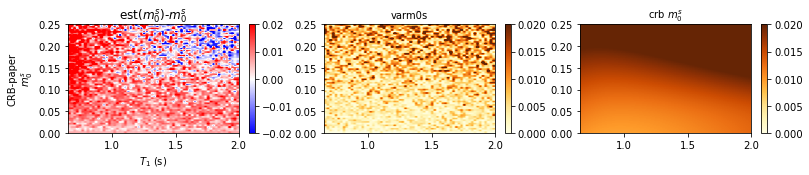

In [25]:
for i in range(len(model_name_list)): 
    model_name=model_name_list[i]
    data = sc.io.loadmat(save_root+'/'+'m0sT1.mat')
    plot_testgrid_m0s(data,model_title_list[i])

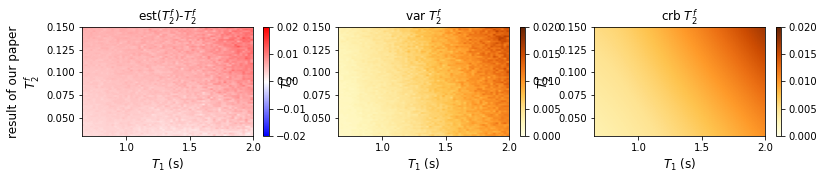

In [23]:
for i in range(len(model_name_list)): 
    model_name=model_name_list[i]   
    data = sc.io.loadmat(save_root+model_name_list[0]+'/'+'T1T2f.mat')
    plot_testgrid_T2(data,'result of our paper')